# Drowsiness Detection System

-



# Loading data and libraries

In [1]:

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 
%matplotlib inline

In [2]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './Fatigue Subjects'

# Image preprocessing : 
### our preprocessing will include
- Detecting faces from images
- Drawing landmarks on our images to increase performance
- Resizing our images 
- LabelEncoding
- Image Augmantation

# Landmarks :
We will use mediapipe to draw landmarks on our images after detecting faces and croping them

In [2]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [3]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
     
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
     
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )

 
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
 
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
 
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE)) 
    return resized_array

In [4]:
imgH, imgW, _=0,0,0 
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
                            
     # Running inference using static_image_mode 
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:  
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [5]:
def face_for_yawn(direc="I:\\Drivr srowsiness\\0 FaceImages", face_cas_path="I:\Drivr srowsiness\haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        print(category)
        path_link = os.path.join(direc, category)
        print(path_link)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

Fatigue Subjects
I:\Drivr srowsiness\0 FaceImages\Fatigue Subjects
0
Active Subjects
I:\Drivr srowsiness\0 FaceImages\Active Subjects
1


In [6]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
9561


In [7]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
8800


### Our images will be like this:

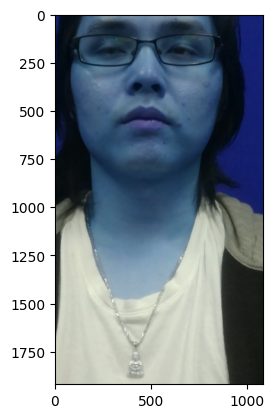

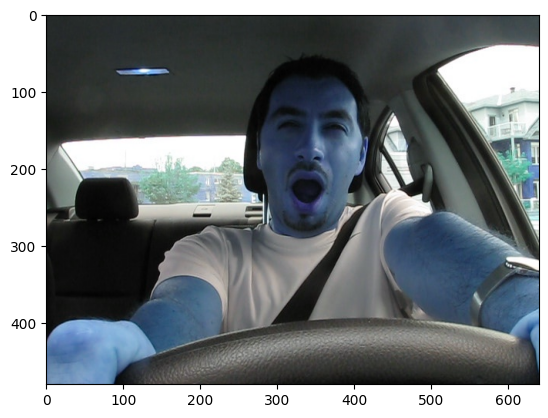

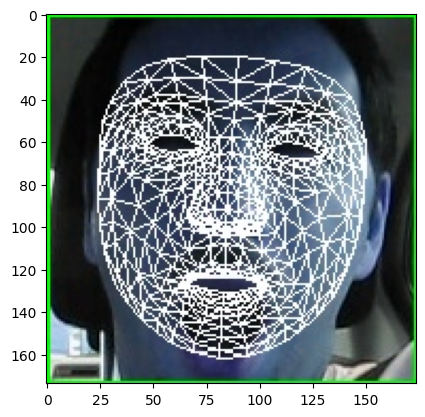

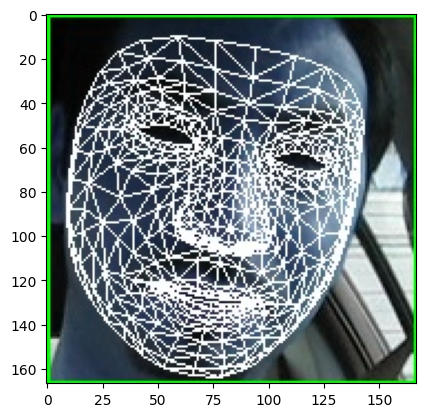

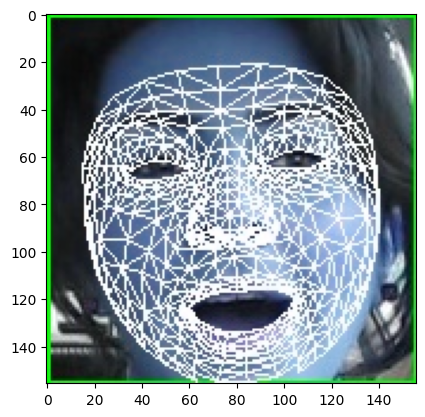

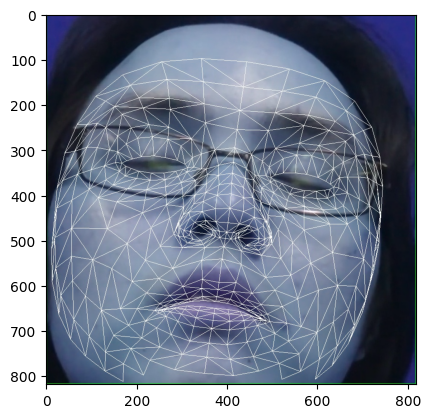

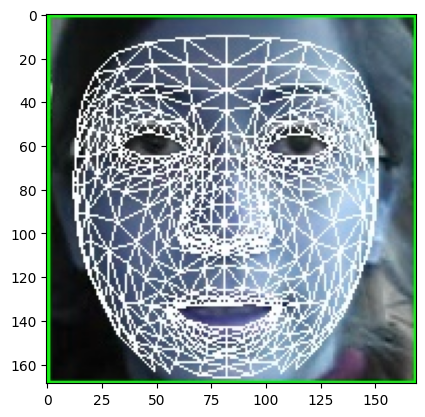

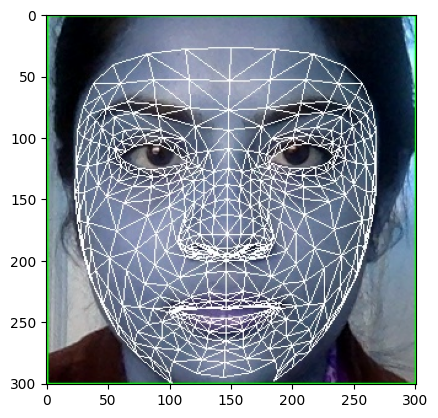

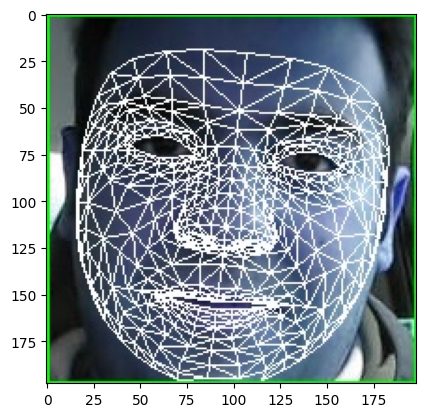

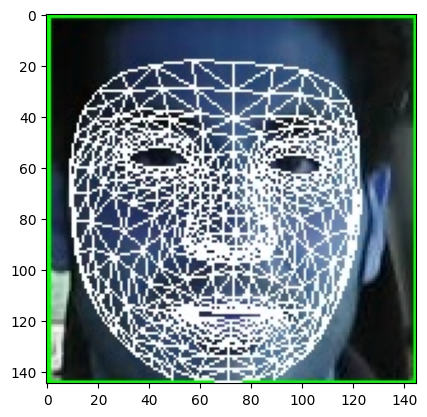

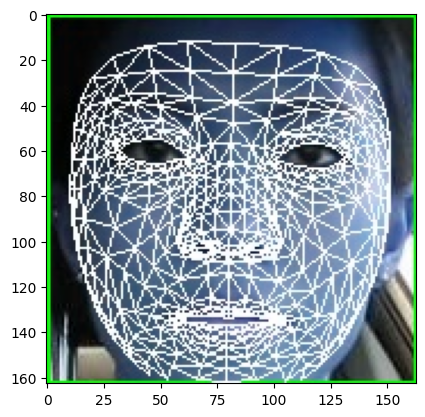

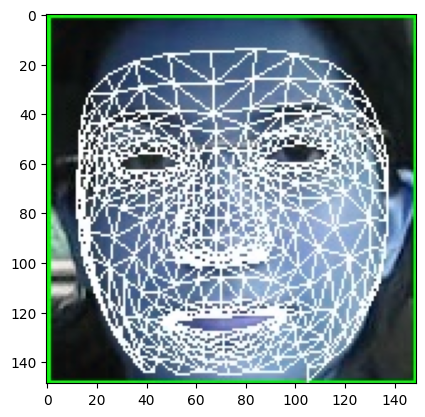

In [8]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

### Resizing images

In [9]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


## separate label and features

In [10]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

## Reshape the array

In [11]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelEncoder

In [12]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

# Splitting

In [13]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [14]:
len(X_test)

3673

In [15]:
len(X_train)

14688

### import some dependencies

In [16]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


# Data Augmentation

In [17]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [18]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 143, 143, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 32)        12832     
                                                                 
 batch_normalization_1 (Bat  (None, 67, 67, 32)        128       
 chNormalization)                                                
                                                        

In [44]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

Epoch 1/70
459/459 [==============================] - 372s 810ms/step - loss: 0.2050 - accuracy: 0.9141 - val_loss: 0.2480 - val_accuracy: 0.9001
Epoch 2/70
459/459 [==============================] - 371s 808ms/step - loss: 0.2036 - accuracy: 0.9178 - val_loss: 0.3038 - val_accuracy: 0.8720
Epoch 3/70
459/459 [==============================] - 364s 792ms/step - loss: 0.1966 - accuracy: 0.9205 - val_loss: 0.2466 - val_accuracy: 0.8993
Epoch 4/70
459/459 [==============================] - 361s 785ms/step - loss: 0.1872 - accuracy: 0.9234 - val_loss: 0.2392 - val_accuracy: 0.9088
Epoch 5/70
459/459 [==============================] - 365s 794ms/step - loss: 0.2011 - accuracy: 0.9186 - val_loss: 0.2084 - val_accuracy: 0.9161
Epoch 6/70
459/459 [==============================] - 375s 818ms/step - loss: 0.1815 - accuracy: 0.9262 - val_loss: 0.2054 - val_accuracy: 0.9183
Epoch 7/70
459/459 [==============================] - 375s 818ms/step - loss: 0.1748 - accuracy: 0.9288 - val_loss: 0.2329 -

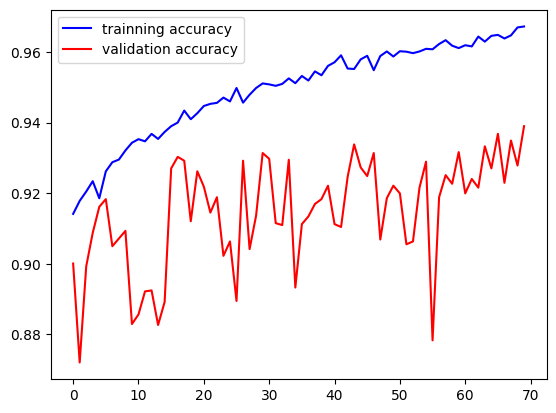

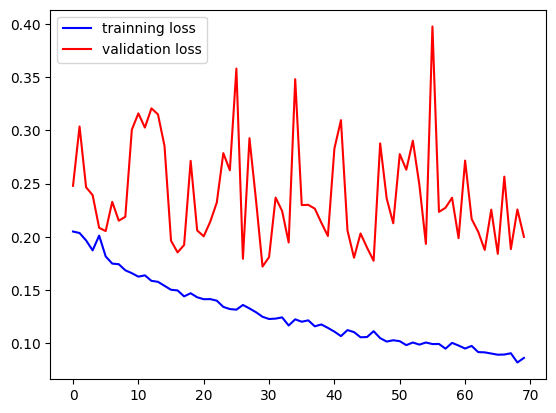

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [46]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
115/115 [==============================] - 21s 186ms/step - loss: 0.2000 - accuracy: 0.9390


{'loss': 0.19996331632137299, 'accuracy': 0.9390144348144531}

In [47]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

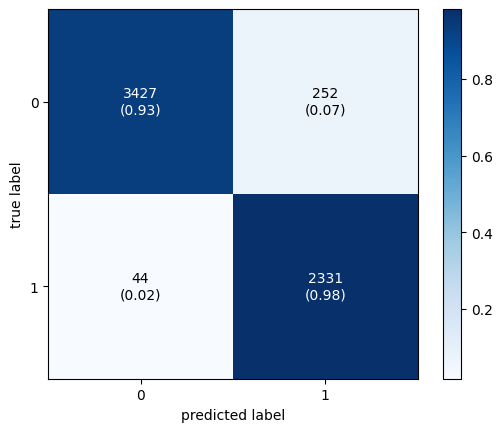

In [48]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Visualizing our CNN architecture

In [50]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:

import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model, legend=True).show()

AttributeError: 'FreeTypeFont' object has no attribute 'getsize'

In [38]:
!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras_sequential_ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3052 sha256=dbf3c5fa68cc1187f80fd82cf5bea76ff944e60a0e01ebe951f871424c225d81
  Stored in directory: c:\users\bbkiv\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\f1\b8\e8\fc04da5f794d3b729628910fdeafe89faa356d95f8ce3aa579
Successfully built keras_sequential_ascii
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    145  145    3
              Conv2D    \|/  -------------------       448     0.0%
                relu   #####    143  143   16
  BatchNormalization    μ|σ  -------------------        64     0.0%
                       #####    143  143   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     71   71   16
       